In [2]:
##import libraries
import pandas as pd
import numpy as np
import os
import glob
from functools import reduce
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast
import plotly.express as px

In [2]:
##read data
ten_yrs_data = pd.read_csv("/content/drive/MyDrive/Ten_years_data.csv", dtype = str)

In [3]:
##display data
ten_yrs_data.head()

,primaryid,caseid,caseversion,i_f_code,event_dt,mfr_dt,init_fda_dt,fda_dt,rept_cod,auth_num,...,dose_unit,dose_form,dose_freq,indi_drug_seq,indi_pt,dsg_drug_seq,start_dt,end_dt,dur,dur_cod
0,120963692,12096369,2,F,2007,20200326,20160220,20200331,EXP,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1314962521,13149625,21,F,2017,20200218,20170125,20200302,EXP,NaN,...,NaN,NaN,NaN,NaN,NaN,17,2006,NaN,NaN,NaN
2,1352573513,13525735,13,F,20170417,20191223,20170509,20200106,EXP,NaN,...,NaN,NaN,NaN,21,Product used for unknown indication,NaN,NaN,NaN,NaN,NaN
3,147306292,14730629,2,F,20180226,20200227,20180406,20200309,EXP,GB-MHRA-ADR 24296496,...,NaN,SOLUTION FOR INJECTION,NaN,1,Diabetes mellitus,1,NaN,20180226,NaN,NaN
4,148324085,14832408,5,F,20080514,20200114,20180501,20200122,EXP,NaN,...,NaN,NaN,NaN,41,Weight decreased,41,2007,NaN,NaN,NaN


**Data** **Cleaning**

In [4]:
## data information
ten_yrs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19324 entries, 0 to 19323
Data columns (total 52 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   primaryid         19324 non-null  object
 1   caseid            19324 non-null  object
 2   caseversion       19324 non-null  object
 3   i_f_code          19324 non-null  object
 4   event_dt          8400 non-null   object
 5   mfr_dt            18935 non-null  object
 6   init_fda_dt       19324 non-null  object
 7   fda_dt            19324 non-null  object
 8   rept_cod          19324 non-null  object
 9   auth_num          1370 non-null   object
 10  mfr_num           18890 non-null  object
 11  mfr_sndr          19262 non-null  object
 12  lit_ref           579 non-null    object
 13  age               10826 non-null  object
 14  age_cod           10827 non-null  object
 15  age_grp           4044 non-null   object
 16  sex               16515 non-null  object
 17  e_sub       

In [5]:
##convert data types

##conver the ff cols into numeric
cols_to_convert = ['primaryid', 'caseid', 'caseversion', 'age', 'wt', 'drug_seq', 'val_vbm',
                  'indi_drug_seq', 'dsg_drug_seq', 'nda_num', 'dose_amt', 'dur']

ten_yrs_data[cols_to_convert] = ten_yrs_data[cols_to_convert].apply(lambda col: pd.to_numeric(col, errors="coerce"))

##convert the ff cols into date
cols_to_date = ['event_dt', 'mfr_dt', 'init_fda_dt','fda_dt', 'rept_dt',
                'exp_dt', 'start_dt', 'end_dt']

ten_yrs_data[cols_to_date] = ten_yrs_data[cols_to_date].apply(lambda col: pd.to_datetime(col, errors = 'coerce'))

##display info
ten_yrs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19324 entries, 0 to 19323
Data columns (total 52 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   primaryid         19324 non-null  int64         
 1   caseid            19324 non-null  int64         
 2   caseversion       19324 non-null  int64         
 3   i_f_code          19324 non-null  object        
 4   event_dt          991 non-null    datetime64[ns]
 5   mfr_dt            18935 non-null  datetime64[ns]
 6   init_fda_dt       19324 non-null  datetime64[ns]
 7   fda_dt            19324 non-null  datetime64[ns]
 8   rept_cod          19324 non-null  object        
 9   auth_num          1370 non-null   object        
 10  mfr_num           18890 non-null  object        
 11  mfr_sndr          19262 non-null  object        
 12  lit_ref           579 non-null    object        
 13  age               10826 non-null  float64       
 14  age_cod           1082

In [6]:
##data set summary
ten_yrs_data.describe()

,primaryid,caseid,caseversion,event_dt,mfr_dt,init_fda_dt,fda_dt,age,wt,rept_dt,drug_seq,val_vbm,exp_dt,nda_num,dose_amt,indi_drug_seq,dsg_drug_seq,start_dt,end_dt,dur
count,1.932400e+04,1.932400e+04,19324.000000,991,18935,19324,19324,10826.000000,3807.000000,19319,19324.000000,19324.0,80,1.461800e+04,5688.000000,15256.000000,7743.000000,1042,2609,567.000000
mean,1.813224e+08,1.660592e+07,1.516922,2016-06-20 00:39:13.985872896,2019-04-20 13:41:24.731977984,2019-06-02 08:27:41.767749888,2019-07-22 18:01:11.537984,153.052004,99.402734,2019-07-20 01:07:45.303587328,5.020544,1.0,2020-10-27 17:42:00,1.531051e+05,10.756593,4.401219,2.543717,2015-10-26 19:04:15.662188032,2019-04-08 08:53:10.187811328,67.315697
min,6.964033e+07,6.964033e+06,1.000000,1991-01-01 00:00:00,1999-02-24 00:00:00,2009-04-08 00:00:00,2014-07-01 00:00:00,0.000000,2.900000,2007-01-17 00:00:00,1.000000,1.0,2010-07-13 00:00:00,9.900000e+01,0.060000,1.000000,1.000000,1976-01-01 00:00:00,1998-10-14 00:00:00,1.000000
25%,1.293475e+08,1.290103e+07,1.000000,2016-01-01 00:00:00,2016-09-30 00:00:00,2016-11-01 00:00:00,2016-12-23 00:00:00,42.000000,81.000000,2016-12-23 00:00:00,1.000000,1.0,2018-03-23 12:00:00,2.188700e+04,1.000000,1.000000,1.000000,2015-01-01 00:00:00,2016-11-01 00:00:00,4.500000
50%,1.601319e+08,1.601312e+07,1.000000,2017-01-01 00:00:00,2019-01-02 00:00:00,2019-02-27 00:00:00,2019-02-27 00:00:00,52.000000,95.000000,2019-02-27 00:00:00,1.000000,1.0,2020-06-30 00:00:00,2.063210e+05,1.800000,1.000000,1.000000,2017-01-01 00:00:00,2019-01-17 00:00:00,14.000000
75%,2.050214e+08,2.031193e+07,1.000000,2018-01-01 00:00:00,2021-12-17 00:00:00,2022-01-08 00:00:00,2022-02-22 00:00:00,62.000000,112.335000,2022-02-22 00:00:00,2.000000,1.0,2023-09-30 00:00:00,2.063210e+05,3.000000,1.000000,2.000000,2019-01-01 00:00:00,2022-01-02 00:00:00,60.500000
max,2.373172e+09,2.479141e+07,95.000000,2021-01-01 00:00:00,2024-12-26 00:00:00,2024-12-31 00:00:00,2024-12-31 00:00:00,27989.000000,446.000000,2024-12-31 00:00:00,558.000000,1.0,2026-07-31 00:00:00,1.980710e+08,1800.000000,541.000000,183.000000,2024-01-01 00:00:00,2024-12-19 00:00:00,2920.000000
std,1.619005e+08,4.200208e+06,2.201272,NaN,NaN,NaN,NaN,1430.519084,29.729863,NaN,20.851839,0.0,NaN,2.317210e+06,51.072810,20.299455,6.351161,NaN,NaN,190.731734


In [7]:
##Missing values

##null counts
print(ten_yrs_data.isnull().sum())

primaryid               0
caseid                  0
caseversion             0
i_f_code                0
event_dt            18333
mfr_dt                389
init_fda_dt             0
fda_dt                  0
rept_cod                0
auth_num            17954
mfr_num               434
mfr_sndr               62
lit_ref             18745
age                  8498
age_cod              8497
age_grp             15280
sex                  2809
e_sub                   0
wt                  15517
wt_cod              15517
rept_dt                 5
to_mfr              17044
occp_cod              150
reporter_country        0
occr_country          340
outc_cod            10683
pt                      0
drug_seq                0
role_cod                0
drugname                0
prod_ai                 3
val_vbm                 0
route                7972
dose_vbm             4032
cum_dose_chr        18931
cum_dose_unit       18931
dechal               8368
rechal              13400
lot_num     

In [8]:
##null values percentage
print((ten_yrs_data.isnull().sum()/len(ten_yrs_data))*100)

primaryid            0.000000
caseid               0.000000
caseversion          0.000000
i_f_code             0.000000
event_dt            94.871662
mfr_dt               2.013041
init_fda_dt          0.000000
fda_dt               0.000000
rept_cod             0.000000
auth_num            92.910371
mfr_num              2.245912
mfr_sndr             0.320845
lit_ref             97.003726
age                 43.976402
age_cod             43.971227
age_grp             79.072656
sex                 14.536328
e_sub                0.000000
wt                  80.299110
wt_cod              80.299110
rept_dt              0.025875
to_mfr              88.201201
occp_cod             0.776237
reporter_country     0.000000
occr_country         1.759470
outc_cod            55.283585
pt                   0.000000
drug_seq             0.000000
role_cod             0.000000
drugname             0.000000
prod_ai              0.015525
val_vbm              0.000000
route               41.254399
dose_vbm  

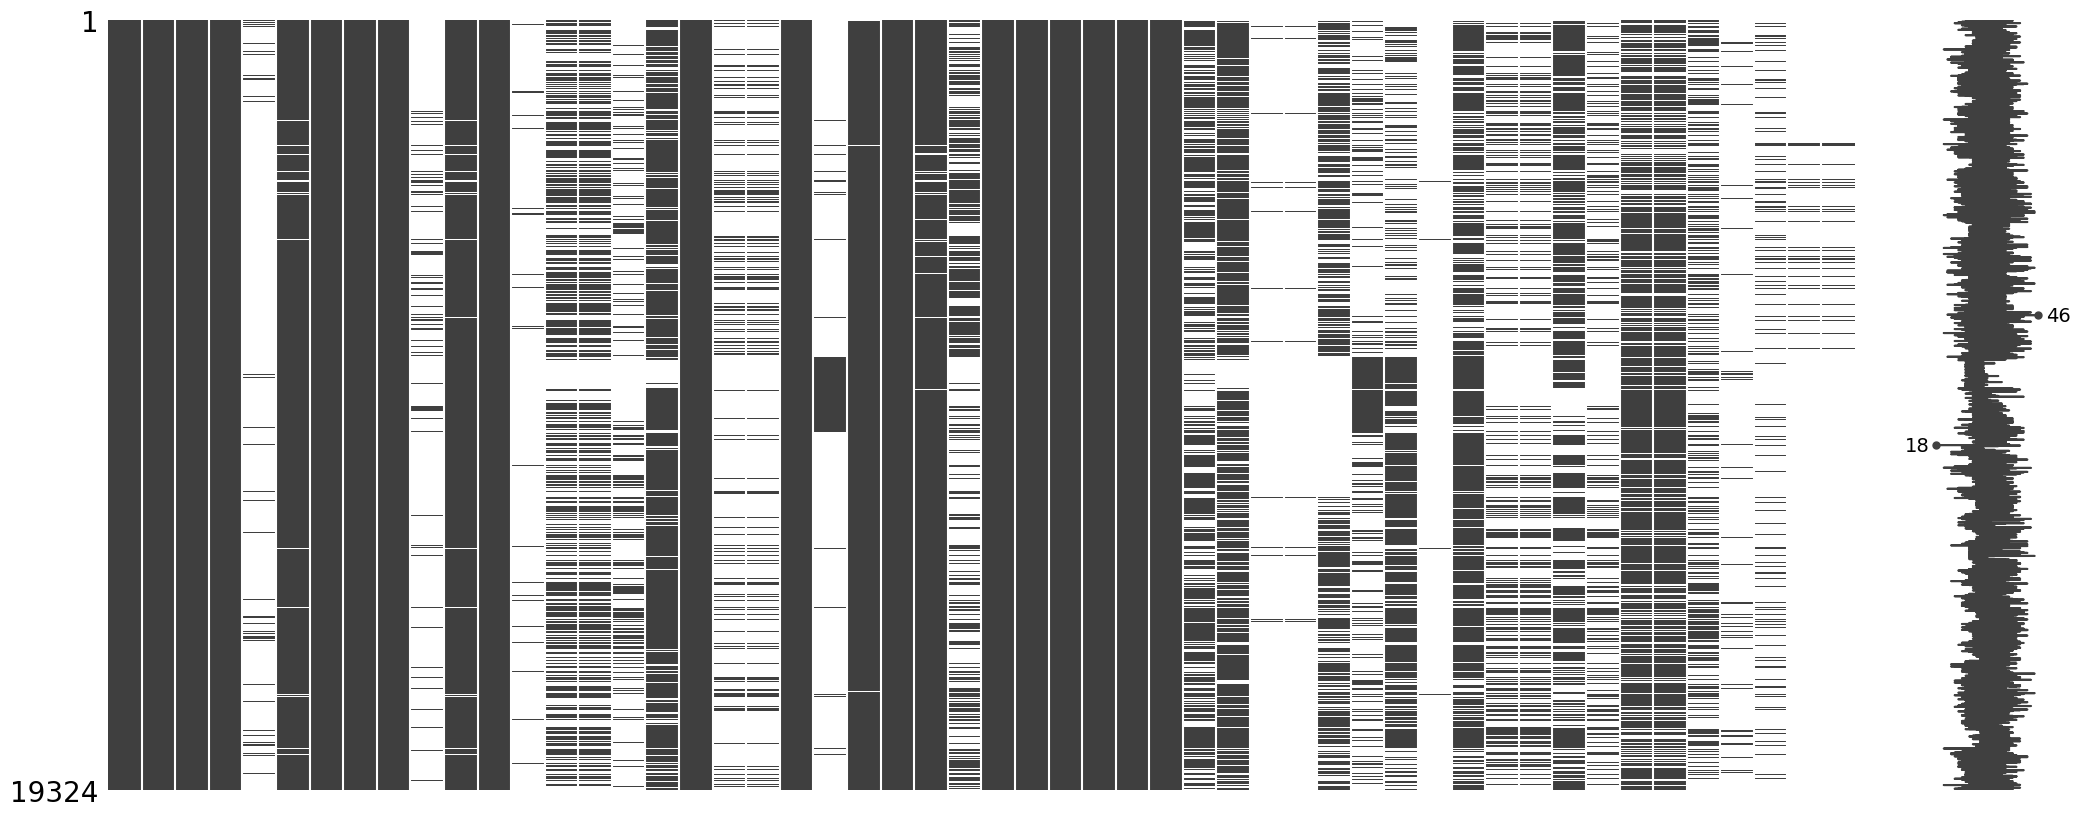

In [9]:
##visualisation of missing values
##plot
msno.matrix(ten_yrs_data)
plt.show()

In [10]:
## remove columns with >60% missing values
## remove cols - evt_dt, cum_dose_chr, cum_dose_unit, rechal, exp_dt,
## dose_amt, dose_unit, dose_freq, auth_num, lit_ref, age_grp, to_mfr,
## wt, wt_cod, start_dt, end_dt, dur, dur_cod

##drop cols with more than 60% missing values
ten_yrs_data = ten_yrs_data.dropna(axis=1, thresh=len(ten_yrs_data)*0.4)

##display data
ten_yrs_data

,primaryid,caseid,caseversion,i_f_code,mfr_dt,init_fda_dt,fda_dt,rept_cod,mfr_num,mfr_sndr,...,val_vbm,route,dose_vbm,dechal,lot_num,nda_num,dose_form,indi_drug_seq,indi_pt,dsg_drug_seq
0,120963692,12096369,2,F,2020-03-26,2016-02-20,2020-03-31,EXP,US-ASTRAZENECA-2008BM06688,ASTRAZENECA,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1314962521,13149625,21,F,2020-02-18,2017-01-25,2020-03-02,EXP,CA-CELLTRION INC.-2017CA000780,CELLTRION,...,1,Unknown,"UNK, 1X/DAY",NaN,NaN,NaN,NaN,NaN,NaN,17.0
2,1352573513,13525735,13,F,2019-12-23,2017-05-09,2020-01-06,EXP,CA-ROCHE-1931885,ROCHE,...,1,Unknown,NaN,U,NaN,NaN,NaN,21.0,Product used for unknown indication,NaN
3,147306292,14730629,2,F,2020-02-27,2018-04-06,2020-03-09,EXP,GB-NOVOPROD-593576,NOVO NORDISK,...,1,Subcutaneous,1.8 MG,NaN,NaN,22341.0,SOLUTION FOR INJECTION,1.0,Diabetes mellitus,1.0
4,148324085,14832408,5,F,2020-01-14,2018-05-01,2020-01-22,EXP,US-ASTRAZENECA-2018SE50167,ASTRAZENECA,...,1,NaN,NaN,NaN,NaN,NaN,NaN,41.0,Weight decreased,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19319,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,"0.6 MILLIGRAM, QD",D,NaN,NaN,INJECTION,NaN,NaN,NaN
19320,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,"1.8 MILLIGRAM, QD",D,NaN,NaN,INJECTION,NaN,NaN,NaN
19321,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,UNK UNK,D,NaN,NaN,INJECTION,NaN,NaN,NaN
19322,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,"1.8 MILLIGRAM, QD",D,NaN,NaN,INJECTION,NaN,NaN,NaN


In [11]:
##null values percentage
print((ten_yrs_data.isnull().sum()/len(ten_yrs_data)*100))

primaryid            0.000000
caseid               0.000000
caseversion          0.000000
i_f_code             0.000000
mfr_dt               2.013041
init_fda_dt          0.000000
fda_dt               0.000000
rept_cod             0.000000
mfr_num              2.245912
mfr_sndr             0.320845
age                 43.976402
age_cod             43.971227
sex                 14.536328
e_sub                0.000000
rept_dt              0.025875
occp_cod             0.776237
reporter_country     0.000000
occr_country         1.759470
outc_cod            55.283585
pt                   0.000000
drug_seq             0.000000
role_cod             0.000000
drugname             0.000000
prod_ai              0.015525
val_vbm              0.000000
route               41.254399
dose_vbm            20.865245
dechal              43.303664
lot_num             44.436970
nda_num             24.353136
dose_form           35.230801
indi_drug_seq       21.051542
indi_pt             21.051542
dsg_drug_s

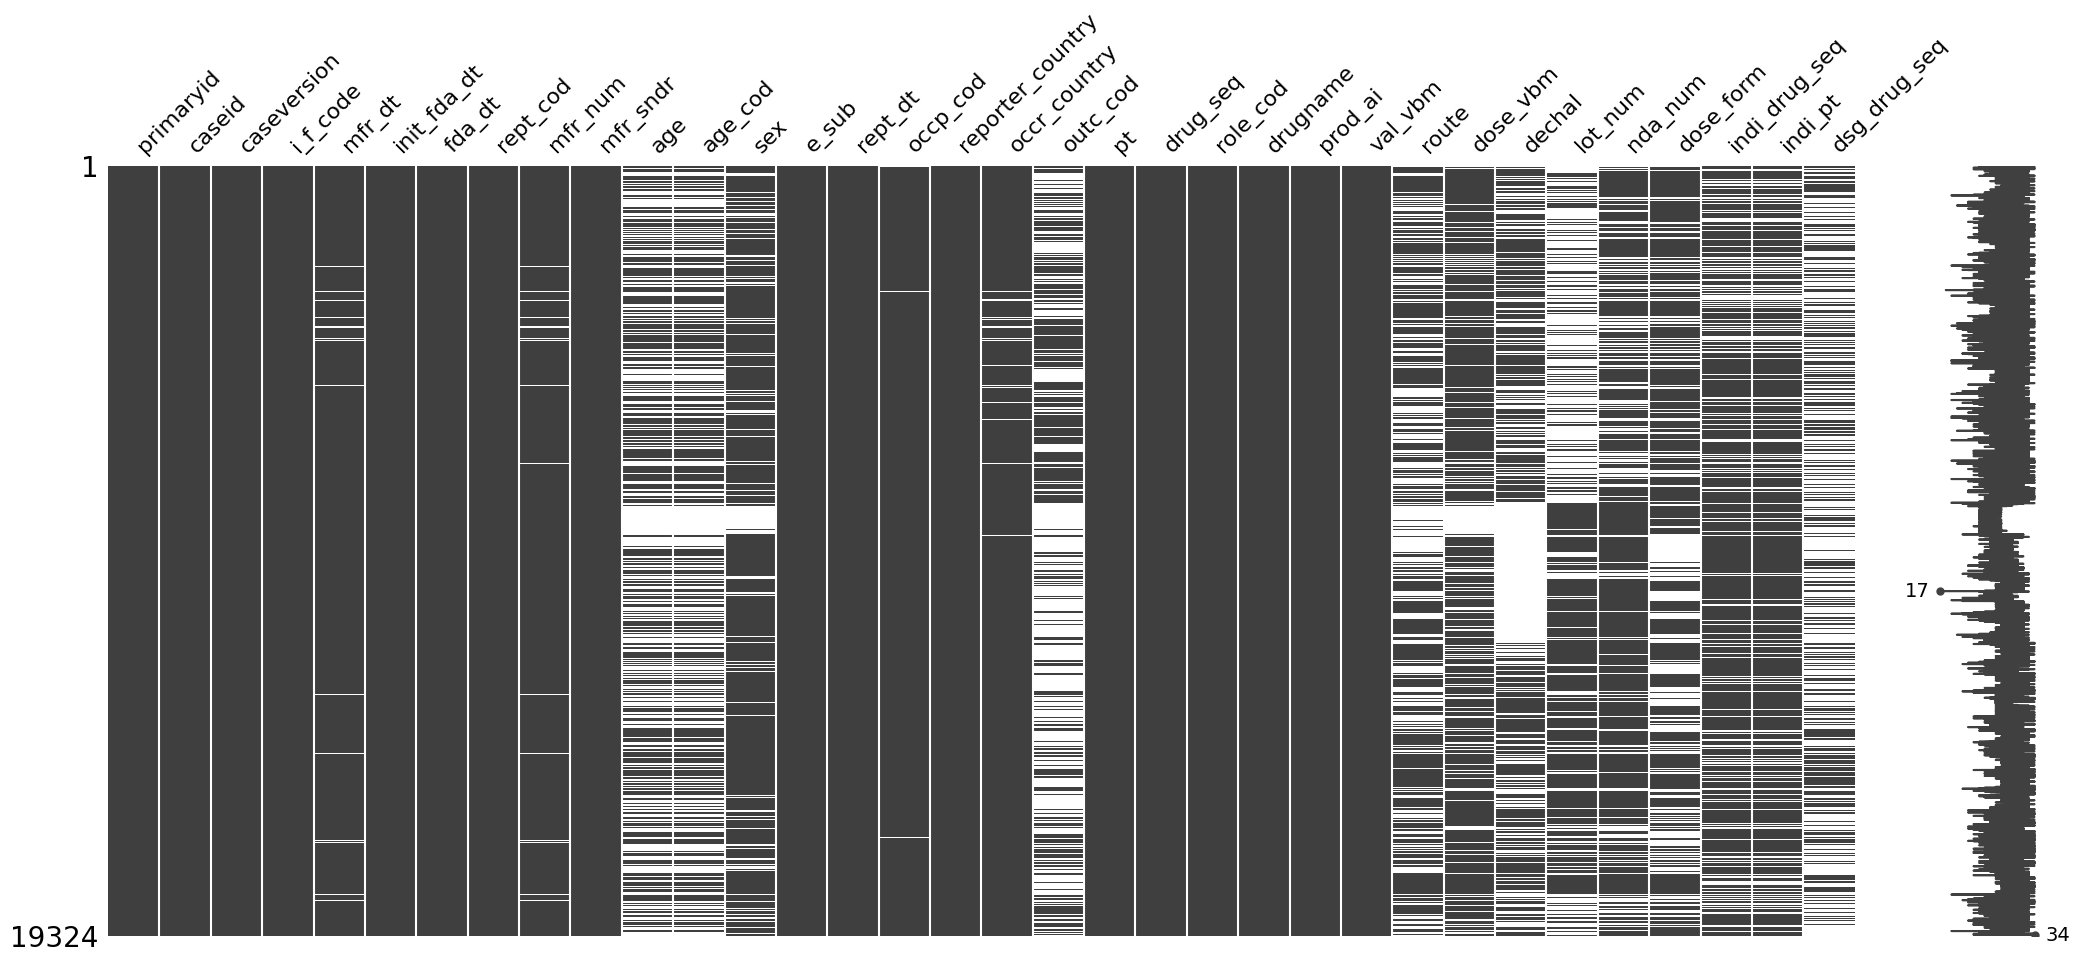

In [12]:
##visualise missing values
msno.matrix(ten_yrs_data)
plt.show()

In [13]:
##remove rows with less than 10% missing values

# Identify columns with less than 10% missing values
cols_below_10pct_missing = ten_yrs_data.columns[(ten_yrs_data.isnull().mean() > 0) & (ten_yrs_data.isnull().mean() <= 0.1)]

print(cols_below_10pct_missing)

Index(['mfr_dt', 'mfr_num', 'mfr_sndr', 'rept_dt', 'occp_cod', 'occr_country',
       'prod_ai'],
      dtype='object')


In [14]:
# Drop rows where these columns have missing values
ten_yrs_data = ten_yrs_data[~ten_yrs_data[cols_below_10pct_missing].isnull().any(axis=1)]

##display data
ten_yrs_data

,primaryid,caseid,caseversion,i_f_code,mfr_dt,init_fda_dt,fda_dt,rept_cod,mfr_num,mfr_sndr,...,val_vbm,route,dose_vbm,dechal,lot_num,nda_num,dose_form,indi_drug_seq,indi_pt,dsg_drug_seq
1,1314962521,13149625,21,F,2020-02-18,2017-01-25,2020-03-02,EXP,CA-CELLTRION INC.-2017CA000780,CELLTRION,...,1,Unknown,"UNK, 1X/DAY",NaN,NaN,NaN,NaN,NaN,NaN,17.0
2,1352573513,13525735,13,F,2019-12-23,2017-05-09,2020-01-06,EXP,CA-ROCHE-1931885,ROCHE,...,1,Unknown,NaN,U,NaN,NaN,NaN,21.0,Product used for unknown indication,NaN
3,147306292,14730629,2,F,2020-02-27,2018-04-06,2020-03-09,EXP,GB-NOVOPROD-593576,NOVO NORDISK,...,1,Subcutaneous,1.8 MG,NaN,NaN,22341.0,SOLUTION FOR INJECTION,1.0,Diabetes mellitus,1.0
5,151265324,15126532,4,F,2020-01-02,2018-07-10,2020-01-07,EXP,US-JNJFOC-20180709795,JOHNSON AND JOHNSON,...,1,Unknown,NaN,D,NaN,NaN,NaN,4.0,Product used for unknown indication,NaN
6,152211425,15221142,5,F,2020-01-22,2018-07-31,2020-01-30,EXP,PT-AUROBINDO-AUR-APL-2018-038679,AUROBINDO,...,1,Oral,"100 MILLIGRAM, ONCE A DAY",Y,NaN,NaN,CAPSULE,17.0,Weight decreased,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19319,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,"0.6 MILLIGRAM, QD",D,NaN,NaN,INJECTION,NaN,NaN,NaN
19320,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,"1.8 MILLIGRAM, QD",D,NaN,NaN,INJECTION,NaN,NaN,NaN
19321,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,UNK UNK,D,NaN,NaN,INJECTION,NaN,NaN,NaN
19322,172138441,17213844,1,I,2019-12-16,2019-12-30,2019-12-30,EXP,CA-MYLANLABS-2019M1126884,MYLAN,...,1,Subcutaneous,"1.8 MILLIGRAM, QD",D,NaN,NaN,INJECTION,NaN,NaN,NaN


In [15]:
##null values percentage
print((ten_yrs_data.isnull().sum()/len(ten_yrs_data)*100))

primaryid            0.000000
caseid               0.000000
caseversion          0.000000
i_f_code             0.000000
mfr_dt               0.000000
init_fda_dt          0.000000
fda_dt               0.000000
rept_cod             0.000000
mfr_num              0.000000
mfr_sndr             0.000000
age                 45.142275
age_cod             45.136917
sex                 14.934891
e_sub                0.000000
rept_dt              0.000000
occp_cod             0.000000
reporter_country     0.000000
occr_country         0.000000
outc_cod            56.406409
pt                   0.000000
drug_seq             0.000000
role_cod             0.000000
drugname             0.000000
prod_ai              0.000000
val_vbm              0.000000
route               40.828466
dose_vbm            19.002197
dechal              43.030920
lot_num             42.977332
nda_num             21.917368
dose_form           33.481593
indi_drug_seq       20.288302
indi_pt             20.288302
dsg_drug_s

In [16]:
##unique values for age_cod
ten_yrs_data['age_cod'].unique()

array([nan, 'YR', 'MON', 'DY', 'DEC', 'WK'], dtype=object)

In [17]:
##unique values at sex col
ten_yrs_data['sex'].unique()

array([nan, 'M', 'F'], dtype=object)

In [18]:
##value counts
ten_yrs_data['sex'].value_counts()

,count
sex,
F,12470
M,3404


In [19]:
##unique values for outc_cod
arr = np.array(ten_yrs_data['outc_cod'])

# Step 1: Flatten and parse the string lists
unique_items = set()
for item in arr:
    if isinstance(item, str):
        try:
            parsed = ast.literal_eval(item)
            unique_items.update(parsed)
        except Exception as e:
            print(f"Error parsing item: {item} | {e}")

# Step 2: Print sorted list of unique values
print(sorted(unique_items))

['CA', 'DE', 'DS', 'HO', 'LT', 'OT']


In [20]:
##unique values for route col
ten_yrs_data['route'].unique()

array(['Unknown', 'Subcutaneous', 'Oral', nan, 'Parenteral', 'Other',
       'Transplacental', 'Intramuscular', 'Rectal', 'Cutaneous',
       'Endocervical', 'Topical', 'Intravenous (not otherwise specified)',
       'ORAL', 'UNKNOWN', 'SUBCUTANEOUS', 'TRANSPLACENTAL', 'Intradermal',
       'Sublingual'], dtype=object)

In [21]:
##unique values for dose_vbm
ten_yrs_data['dose_vbm'].unique()

array(['UNK, 1X/DAY', nan, '1.8 MG', ..., '0.6 MG, QD(IN MORNING)',
       '6 MG/DAY, 0-0-1-0', '2.4 MILLIGRAM, QD'], dtype=object)

In [22]:
##unique values for dechal col
ten_yrs_data['dechal'].unique()

array([nan, 'U', 'D', 'Y', 'N'], dtype=object)

In [23]:
##value counts for dechal col
ten_yrs_data['dechal'].value_counts()

,count
dechal,
U,6092
Y,3218
N,693
D,628


In [24]:
##unique values for lot_num
ten_yrs_data['lot_num'].unique()

array([nan, ' HZF8853', ' HZF9167', ' HZF9734', ' HP53325', ' JZFD436',
       ' HZF7574', ' JP51557', ' 9812', ' 15234', ' JP51913', ' JP50601',
       ' UNKNOWN', ' 104571XC', ' UNK', ' JP52967', ' 12356', ' 11495',
       ' 15994', ' 12355', ' 18200', ' 15233', ' 5790', ' 15615',
       ' JP51371', ' 8814', ' JP52255', ' JZFG794', ' JZFB266',
       ' 61906XB', ' HZF7917', ' HZF8459', ' HZF9443', ' HZFA728',
       ' HZFA073', ' HP53176', ' HZF6071', ' HZFA877', ' HZF7572',
       ' HZF5680', ' HZFA228', ' HZF7456', ' JZFD205', ' JP50740',
       ' JZFC391', ' GZF4087', ' HZF7049', ' JZF7572', ' JP51543',
       ' JZFB691', ' JZFF698', ' JZFF289', ' JZFE564', ' FZF0134',
       ' HP51867', ' HP50909', ' JZFD433', ' HZF7916', ' JZFB512',
       ' 9813', ' U NK', ' 11613', ' 104573XC', ' 5511', ' 18593',
       ' 10947', ' 5276', ' JP53459', ' JZFB511', ' JP53782', ' 18594',
       ' 5275', ' 5405', ' 18626', ' JP52643', ' 105463XB', ' 20184',
       ' KS6AK14', ' KZFJ179', ' JZFG972'

In [25]:
##value counts for nda_num
ten_yrs_data['nda_num'].value_counts()

,count
nda_num,
206321.0,8190
21887.0,5897
20766.0,256
22341.0,224
198071001.0,2
75765.0,1
7157.0,1


In [26]:
##unique values for dose_form
ten_yrs_data['dose_form'].unique()

array([nan, 'SOLUTION FOR INJECTION', 'CAPSULE', 'INJECTION', 'UNK',
       'UNKNOWN', 'FORMULATION UNKNOWN',
       'SOLUTION FOR INJECTION/INFUSION', 'TABLETS',
       'SOLN FOR INJECT IN PRE-FILLED SYRINGE',
       'SOLUTION FOR INJECTION IN PRE-FILLED PEN', 'UNSPECIFIED',
       'TABLET', 'CHEWABLE/DISPERSIBLE TABLET', 'CHEWABLE TABLET',
       'LIQUID', 'Solution for injection', 'Capsule', 'Injection',
       'Unknown', 'Solution for injection/infusion',
       'Solution for injection in pre-filled pen', 'Capsules', 'Solution',
       'Tablet', '5', 'Solution for injection in pre-filled syringe',
       'prefilled syringes', 'Infusion', 'Formulation unknown',
       'Chewable/dispersible tablet', 'Oromucosal suspension',
       'INJECTION, SOLUTION', 'PRE-FILLED SYRINGE', 'Capsule, hard',
       'CAPSULE, HARD', 'SOLUTION', 'GRANULES'], dtype=object)

In [27]:
#unique values for indi_drug_seq col
ten_yrs_data['indi_drug_seq'].unique()

array([ nan,  21.,   1.,   4.,  17.,  35.,   5.,   6.,   7.,  14.,  15.,
        33.,  10.,   3.,   2.,   8.,  12.,   9.,  13.,  16.,  11.,  19.,
        50.,  18.,  52.,  20.,  43.,  22.,  84.,  26.,  39.,  29.,  31.,
        27.,  28.,  45.,  36.,  40., 122.,  49.,  55.,  80.,  25., 188.,
        34.,  24.,  37.,  76.,  57.,  23., 147.,  42., 140., 259., 136.,
       127., 151., 229.,  60.,  61.,  58., 142., 302., 129., 159.,  54.,
       189., 130.,  51.,  95., 153., 113., 178., 295., 141., 173.,  94.,
       116.,  30., 155., 194., 249., 503.,  32., 149., 201., 202., 154.,
       150., 262., 199., 177., 220., 320., 205.,  85., 218.,  53., 119.,
       111., 180., 175., 219., 261., 315.,  44.,  62., 216.,  87.,  64.,
        79., 107., 168., 169.,  47., 133., 512., 152., 183.,  65.,  66.,
       171., 209., 233., 234., 235., 118., 117.,  91.,  90., 309., 102.,
        71., 101.,  99., 135., 232., 182., 157., 372., 184., 214., 469.,
       210., 313., 167., 128.,  38.,  48.,  72.,  6

In [28]:
#unique values for indi_pt col
ten_yrs_data['indi_pt'].unique()

array([nan, 'Product used for unknown indication', 'Diabetes mellitus',
       'Weight decreased', 'Weight control', 'Obesity',
       'Type 2 diabetes mellitus', 'Hyperglycaemia', 'Weight loss diet',
       'Anxiety', 'Insulin resistance', 'Glucose tolerance impaired',
       'Overweight', 'Hypertension', 'Type 1 diabetes mellitus',
       'Glycosylated haemoglobin abnormal', 'Suicide attempt',
       'Blood glucose', 'Hyperlipidaemia', 'Abnormal weight gain',
       'Weight increased', 'Food craving', 'Polycystic ovaries',
       'Gastrooesophageal reflux disease', 'Body mass index increased',
       'Premenstrual syndrome', 'Constipation', 'Fat tissue decreased',
       'Pre-existing disease', 'Dyspepsia',
       'Insulin-requiring type 2 diabetes mellitus', 'Oedema',
       'Blood insulin abnormal', 'Diabetic neuropathy',
       'Blood glucose increased', 'Diabetes mellitus management',
       'Gastrointestinal disorder', 'Weight', 'Increased appetite',
       'Medical diet', 'Prop

In [29]:
##unique values for dsg_drug_seq
ten_yrs_data['dsg_drug_seq'].unique()

array([ 17.,  nan,   1.,   9.,  35.,   2.,   3.,   4.,   5.,   8.,   6.,
        11.,  26.,  10.,  18.,  16.,   7.,  14.,  13.,  25.,  19.,  31.,
        21.,  39.,  33.,  22.,  12.,  20.,  23.,  15.,  24.,  32.,  50.,
        30.,  34.,  53.,  43.,  44.,  45.,  28.,  42.,  46.,  49., 129.,
       166.,  97.,  54., 182., 183.,  36.,  88.,  96.])

**Imputation**

In [30]:
##fill the missing values
ten_yrs_data_cpy = ten_yrs_data.copy()

##fill missing values of age_cod col with Unknown
ten_yrs_data_cpy['age_cod'].fillna('Unknown', inplace = True)

##fill missing values of sex col with Unknown
ten_yrs_data_cpy['sex'].fillna('Unknown', inplace = True)

##fill missing values of the outc_cod col with Unknown
ten_yrs_data_cpy['outc_cod'].fillna('Unkown', inplace = True)

##fill missing values of route col with Unknown
ten_yrs_data_cpy['route'].fillna('Unknown', inplace = True)

##fill missing values of dose_vbm col with UNK
ten_yrs_data_cpy['dose_vbm'].fillna('UNK', inplace = True)

##fill missing values of dechal col with Unknown
ten_yrs_data_cpy['dechal'].fillna('U', inplace = True)

##fill missing values of lot_num col with Unknown
ten_yrs_data_cpy['lot_num'].fillna('UNKNOWN', inplace = True)

##fill missing values of nda_num col with mode value
ten_yrs_data_cpy['nda_num'] = ten_yrs_data_cpy['nda_num'].fillna(ten_yrs_data_cpy['nda_num'].mode()[0])

##fill missing values of dose_form col with Unknown
ten_yrs_data_cpy['dose_form'].fillna('Unknown', inplace = True)

##fill missing values of age col with mean age
ten_yrs_data_cpy['age'] = ten_yrs_data_cpy['age'].fillna(ten_yrs_data_cpy['age'].mean())

##fill missing values of indi_drug_seq col with Unknown
ten_yrs_data_cpy['indi_drug_seq'].fillna('Unknown', inplace = True)

##fill missing values of indi_pt col with Unknown
ten_yrs_data_cpy['indi_pt'].fillna('Unknown', inplace = True)

##fill missing values of dsg_drug_seq col with Unknown
ten_yrs_data_cpy['dsg_drug_seq'].fillna('Unknown', inplace = True)

<ipython-input-30-3c8bacd181c7>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ten_yrs_data_cpy['age_cod'].fillna('Unknown', inplace = True)
<ipython-input-30-3c8bacd181c7>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [31]:
##null value counts
print(ten_yrs_data_cpy.isnull().sum())

primaryid           0
caseid              0
caseversion         0
i_f_code            0
mfr_dt              0
init_fda_dt         0
fda_dt              0
rept_cod            0
mfr_num             0
mfr_sndr            0
age                 0
age_cod             0
sex                 0
e_sub               0
rept_dt             0
occp_cod            0
reporter_country    0
occr_country        0
outc_cod            0
pt                  0
drug_seq            0
role_cod            0
drugname            0
prod_ai             0
val_vbm             0
route               0
dose_vbm            0
dechal              0
lot_num             0
nda_num             0
dose_form           0
indi_drug_seq       0
indi_pt             0
dsg_drug_seq        0
dtype: int64


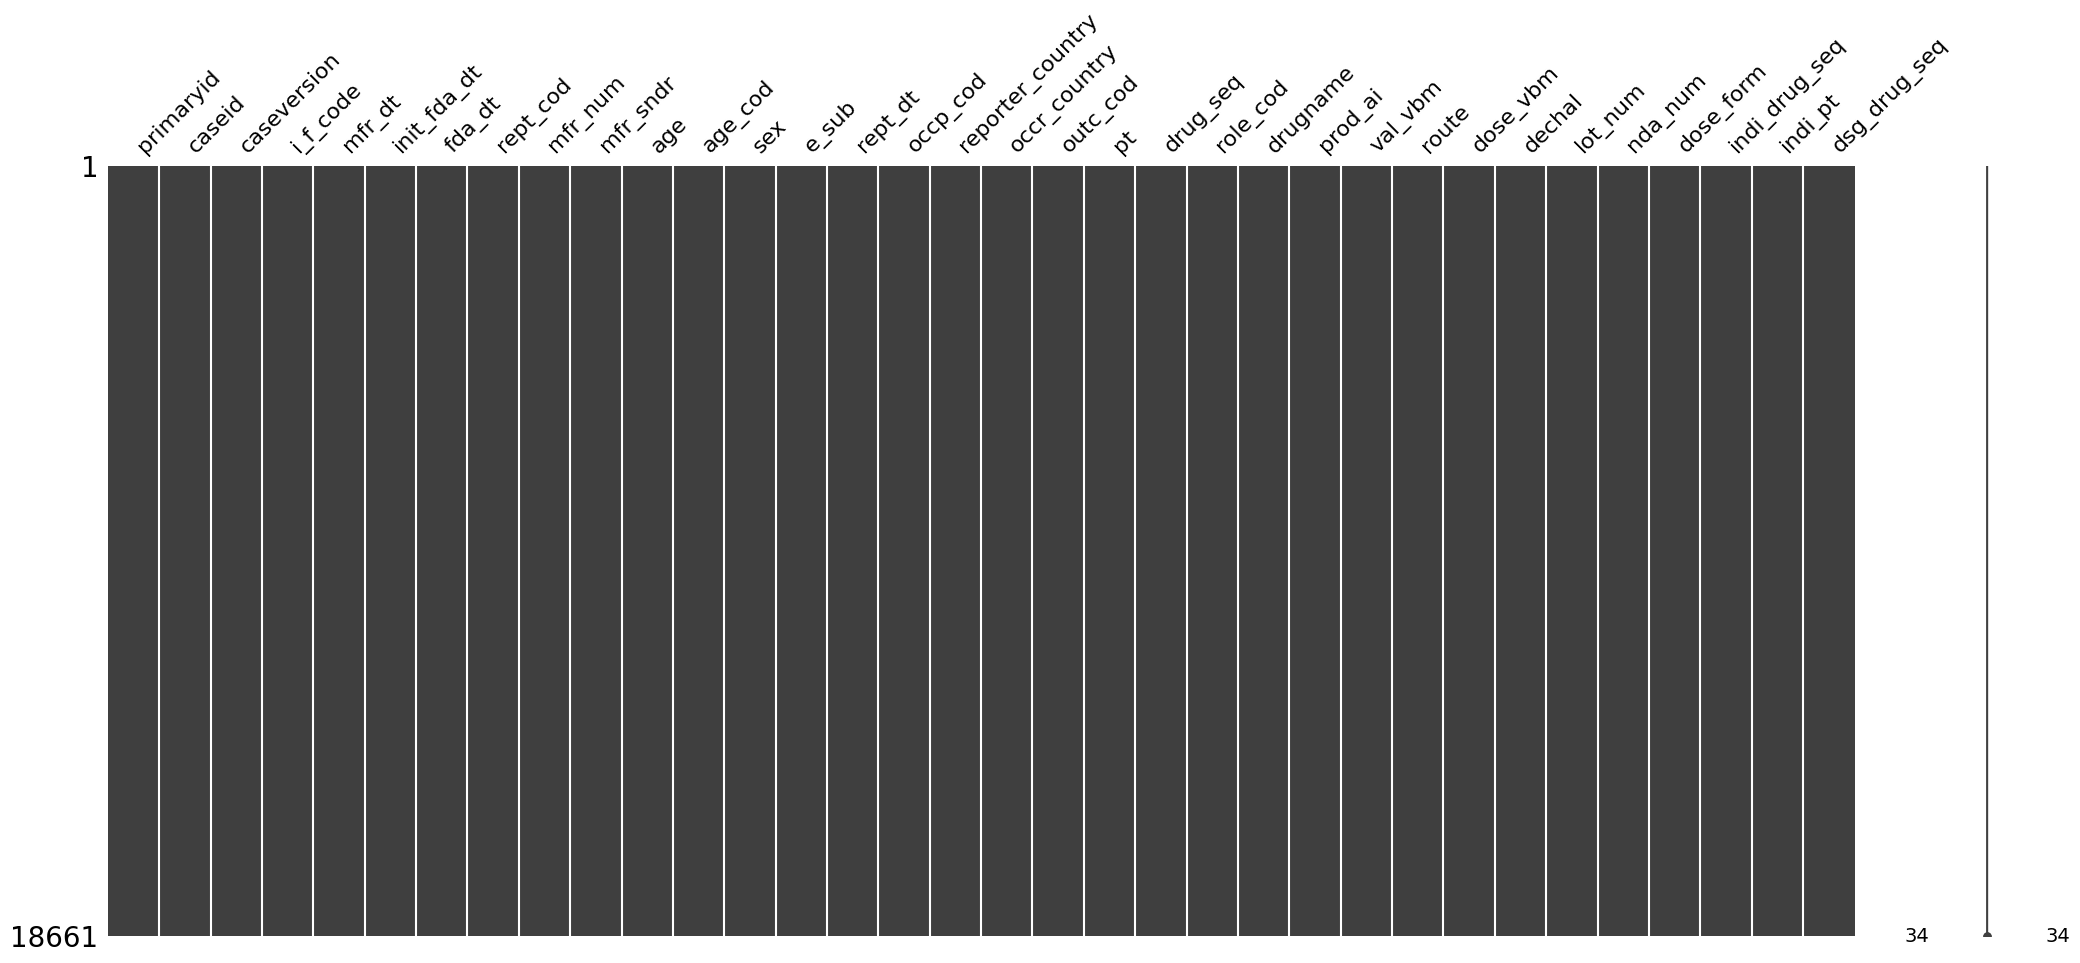

In [32]:
##visualise missing values
msno.matrix(ten_yrs_data_cpy)
plt.show()

In [33]:
##checking for possible duplicates

# Make a temporary copy with list columns converted to strings
df_temp = ten_yrs_data_cpy.copy()

# Convert all list-type columns to strings
for col in df_temp.columns:
    if df_temp[col].apply(lambda x: isinstance(x, list)).any():
        df_temp[col] = df_temp[col].apply(str)

# Now check for duplicates
print(df_temp.duplicated().sum())

0


In [34]:
##convert age to same unit -> year

##mapping function
def convert_age(row):

    if row['age_cod'] == 'YR': ##age is in years

        ##return yrs
        return row['age']

    elif row['age_cod'] == 'MON': ##age is in months

        ##convert months to yrs
        return row['age']/12

    elif row['age_cod'] == 'WK': ##age is in weeks

        ##convert weeks to years
        return row['age']/52

    elif row['age_cod'] == 'DY': ##age is in days

        ##convert days to yrs
        return row['age']/365

    elif row['age_cod'] == 'DEC': ##age is in decade

        ##convert decade to yrs
        return row['age']*10

    else:
        return None

##apply the mapping function to df
ten_yrs_data_cpy['age_in_yrs'] = ten_yrs_data_cpy.apply(convert_age, axis = 1)

In [35]:
##display head
ten_yrs_data_cpy.head()

,primaryid,caseid,caseversion,i_f_code,mfr_dt,init_fda_dt,fda_dt,rept_cod,mfr_num,mfr_sndr,...,route,dose_vbm,dechal,lot_num,nda_num,dose_form,indi_drug_seq,indi_pt,dsg_drug_seq,age_in_yrs
1,1314962521,13149625,21,F,2020-02-18,2017-01-25,2020-03-02,EXP,CA-CELLTRION INC.-2017CA000780,CELLTRION,...,Unknown,"UNK, 1X/DAY",U,UNKNOWN,206321.0,Unknown,Unknown,Unknown,17.0,NaN
2,1352573513,13525735,13,F,2019-12-23,2017-05-09,2020-01-06,EXP,CA-ROCHE-1931885,ROCHE,...,Unknown,UNK,U,UNKNOWN,206321.0,Unknown,21.0,Product used for unknown indication,Unknown,44.0
3,147306292,14730629,2,F,2020-02-27,2018-04-06,2020-03-09,EXP,GB-NOVOPROD-593576,NOVO NORDISK,...,Subcutaneous,1.8 MG,U,UNKNOWN,22341.0,SOLUTION FOR INJECTION,1.0,Diabetes mellitus,1.0,63.0
5,151265324,15126532,4,F,2020-01-02,2018-07-10,2020-01-07,EXP,US-JNJFOC-20180709795,JOHNSON AND JOHNSON,...,Unknown,UNK,D,UNKNOWN,206321.0,Unknown,4.0,Product used for unknown indication,Unknown,70.0
6,152211425,15221142,5,F,2020-01-22,2018-07-31,2020-01-30,EXP,PT-AUROBINDO-AUR-APL-2018-038679,AUROBINDO,...,Oral,"100 MILLIGRAM, ONCE A DAY",Y,UNKNOWN,206321.0,CAPSULE,17.0,Weight decreased,Unknown,48.0


In [36]:
##save the cleaned data to csv file

##file path
csv_file = "/content/drive/MyDrive/Ten_years_data_cleand.csv"

##save the file
ten_yrs_data_cpy.to_csv(csv_file, index = False)
print(f"Cleaned data save to {csv_file} path successfully.")

Cleaned data save to /content/drive/MyDrive/Ten_years_data_cleand.csv path successfully.


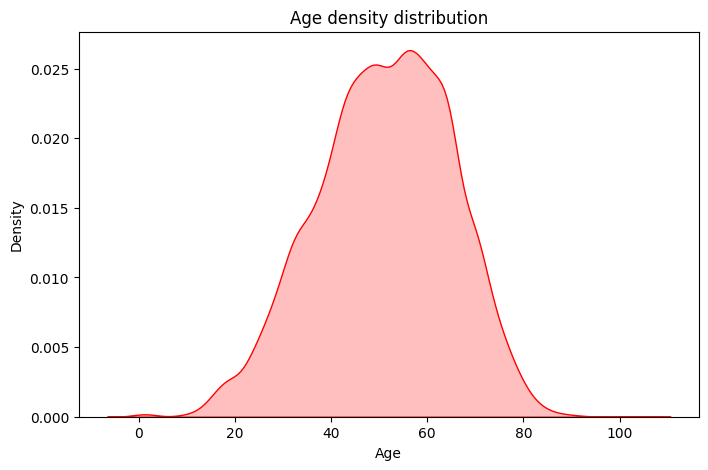

In [37]:
#smoothed age distribution KDE plot

# Ensure age_in_yrs is numeric, coercing errors to NaN
ten_yrs_data_cpy['age_in_yrs'] = pd.to_numeric(ten_yrs_data_cpy['age_in_yrs'], errors='coerce')

# Drop any NaNs
age_cleaned = ten_yrs_data_cpy['age_in_yrs'].dropna()
age_cleaned = age_cleaned[np.isfinite(age_cleaned)]

plt.figure(figsize = (8, 5))
sns.kdeplot(x = age_cleaned, fill = True, color = 'red')
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age density distribution')

plt.grid(False)
plt.show()

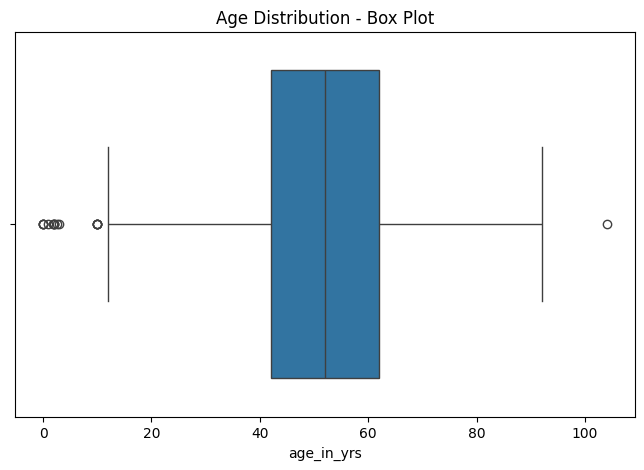

In [38]:
##check for possible outliers

##Boxplot for outlier detection
plt.figure(figsize = (8, 5))
sns.boxplot(x = ten_yrs_data_cpy['age_in_yrs'].dropna())
plt.title('Age Distribution - Box Plot')

plt.grid(False)
plt.show()

In [39]:
min(ten_yrs_data_cpy['age_in_yrs'].dropna())

0.0

In [40]:
max(ten_yrs_data_cpy['age_in_yrs'].dropna())

104.0

In [41]:
ten_yrs_data_cpy.describe()

,primaryid,caseid,caseversion,mfr_dt,init_fda_dt,fda_dt,age,rept_dt,drug_seq,val_vbm,nda_num,age_in_yrs
count,1.866100e+04,1.866100e+04,18661.000000,18661,18661,18661,18661.000000,18661,18661.000000,18661.0,1.866100e+04,10238.000000
mean,1.795023e+08,1.655983e+07,1.499705,2019-04-06 10:59:37.043031296,2019-05-21 15:40:02.379293440,2019-07-08 04:53:37.062322688,89.237472,2019-07-06 01:12:59.958201600,4.807888,1.0,1.644732e+05,51.053491
min,6.964033e+07,6.964033e+06,1.000000,1999-02-24 00:00:00,2009-04-08 00:00:00,2014-07-01 00:00:00,0.000000,2014-07-01 00:00:00,1.000000,1.0,7.157000e+03,0.000000
25%,1.286616e+08,1.285234e+07,1.000000,2016-09-21 00:00:00,2016-10-17 00:00:00,2016-11-25 00:00:00,50.000000,2016-11-25 00:00:00,1.000000,1.0,2.188700e+04,42.000000
50%,1.601309e+08,1.594918e+07,1.000000,2018-12-21 00:00:00,2019-02-11 00:00:00,2019-02-27 00:00:00,70.000000,2019-02-27 00:00:00,1.000000,1.0,2.063210e+05,52.000000
75%,2.046312e+08,2.017511e+07,1.000000,2021-11-16 00:00:00,2021-12-13 00:00:00,2022-02-22 00:00:00,89.237472,2022-02-22 00:00:00,2.000000,1.0,2.063210e+05,62.000000
max,2.345825e+09,2.479141e+07,95.000000,2024-12-26 00:00:00,2024-12-31 00:00:00,2024-12-31 00:00:00,27347.000000,2024-12-31 00:00:00,558.000000,1.0,1.980710e+08,104.000000
std,1.549094e+08,4.198811e+06,2.151612,NaN,NaN,NaN,653.219486,NaN,20.206353,0.0,2.050870e+06,13.892817


**Read** **clean** **data**

In [3]:
##read data
drug_data = pd.read_csv( "/content/drive/MyDrive/Ten_years_data_cleand.csv")

drug_data.head()

,primaryid,caseid,caseversion,i_f_code,mfr_dt,init_fda_dt,fda_dt,rept_cod,mfr_num,mfr_sndr,...,route,dose_vbm,dechal,lot_num,nda_num,dose_form,indi_drug_seq,indi_pt,dsg_drug_seq,age_in_yrs
0,1314962521,13149625,21,F,2020-02-18,2017-01-25,2020-03-02,EXP,CA-CELLTRION INC.-2017CA000780,CELLTRION,...,Unknown,"UNK, 1X/DAY",U,UNKNOWN,206321.0,Unknown,Unknown,Unknown,17.0,NaN
1,1352573513,13525735,13,F,2019-12-23,2017-05-09,2020-01-06,EXP,CA-ROCHE-1931885,ROCHE,...,Unknown,UNK,U,UNKNOWN,206321.0,Unknown,21.0,Product used for unknown indication,Unknown,44.0
2,147306292,14730629,2,F,2020-02-27,2018-04-06,2020-03-09,EXP,GB-NOVOPROD-593576,NOVO NORDISK,...,Subcutaneous,1.8 MG,U,UNKNOWN,22341.0,SOLUTION FOR INJECTION,1.0,Diabetes mellitus,1.0,63.0
3,151265324,15126532,4,F,2020-01-02,2018-07-10,2020-01-07,EXP,US-JNJFOC-20180709795,JOHNSON AND JOHNSON,...,Unknown,UNK,D,UNKNOWN,206321.0,Unknown,4.0,Product used for unknown indication,Unknown,70.0
4,152211425,15221142,5,F,2020-01-22,2018-07-31,2020-01-30,EXP,PT-AUROBINDO-AUR-APL-2018-038679,AUROBINDO,...,Oral,"100 MILLIGRAM, ONCE A DAY",Y,UNKNOWN,206321.0,CAPSULE,17.0,Weight decreased,Unknown,48.0


**Adverse Events Frequency Counts**

In [5]:
##frequency count of AEs
pt_series = drug_data['pt'].dropna()
pt_series = pt_series[pt_series.map(lambda x: len(x) > 0)]  # filter out empty lists

# Flatten and count
reaction_counts = Counter(
    reaction.strip()
    for reactions in pt_series
    for reaction in ast.literal_eval(reactions)
)

##Display reaction counts
reaction_df = pd.DataFrame.from_dict(reaction_counts, orient='index', columns=['count']).reset_index()
reaction_df.columns = ['reaction', 'count']
print(reaction_df.sort_values(by='count', ascending=False))

                             reaction  count
116                  Drug ineffective   3277
18                             Nausea   2293
63                          Diarrhoea   1448
25                           Vomiting   1333
8                    Weight increased    945
...                               ...    ...
2813           Small fibre neuropathy      1
2810              Colitis microscopic      1
2808        Blood magnesium decreased      1
2770  Exposure to extreme temperature      1
2773                  Foot amputation      1

[2838 rows x 2 columns]


In [6]:
top_20 = reaction_counts.most_common(20)
top_20_df = pd.DataFrame(top_20, columns = ['reaction', 'count'])

print(top_20_df)

                   reaction  count
0          Drug ineffective   3277
1                    Nausea   2293
2                 Diarrhoea   1448
3                  Vomiting   1333
4          Weight increased    945
5                  Headache    878
6             Off label use    850
7              Constipation    839
8                   Fatigue    796
9              Steatorrhoea    782
10     Abdominal pain upper    714
11    Product quality issue    655
12                 Dyspnoea    620
13  Treatment noncompliance    617
14           Abdominal pain    579
15                  Anxiety    554
16                  Malaise    547
17         Weight loss poor    521
18         Rectal discharge    501
19                Dizziness    492


<ipython-input-7-1207ec5707e2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_df, x='count', y='reaction', palette='viridis')


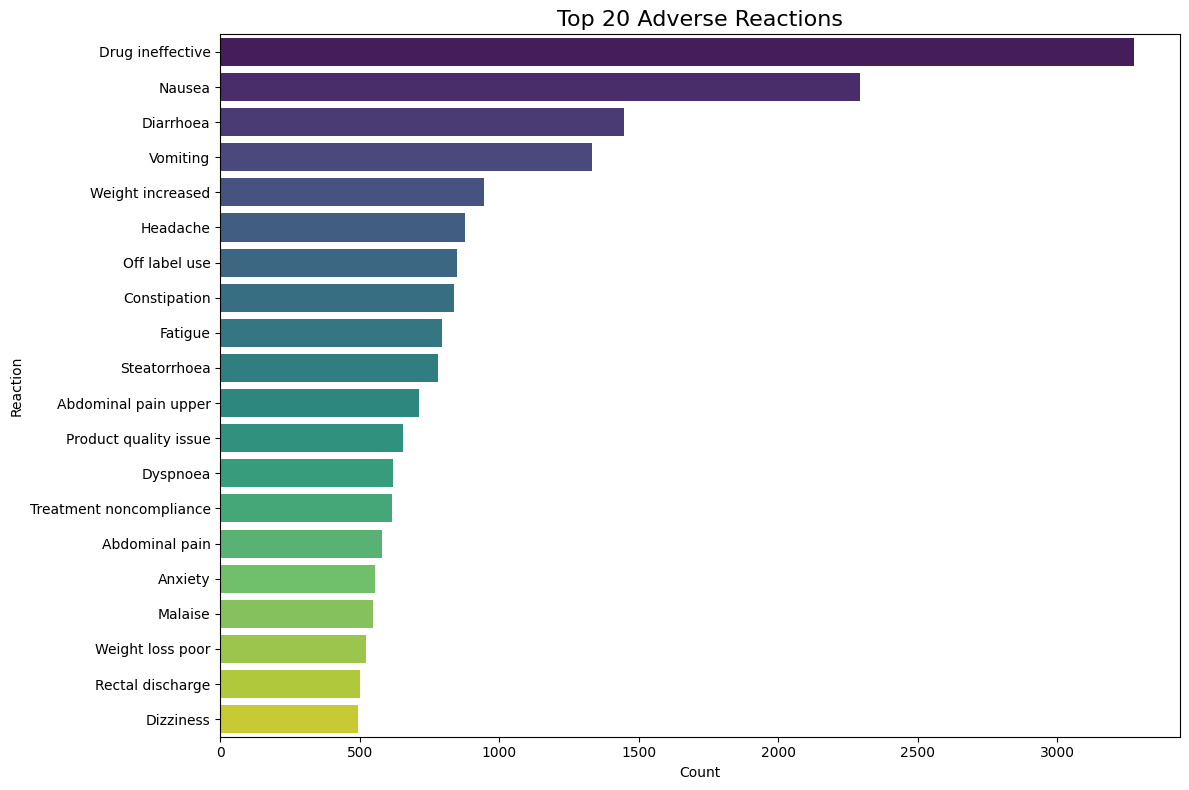

In [7]:
# Ensure plot is in notebook (if using Jupyter)
%matplotlib inline

plt.figure(figsize=(12, 8))
sns.barplot(data=top_20_df, x='count', y='reaction', palette='viridis')

plt.title('Top 20 Adverse Reactions', fontsize=16)
plt.xlabel('Count')
plt.ylabel('Reaction')
plt.tight_layout()
plt.show()

In [8]:
#copy drug data
df = drug_data.copy()

# Convert stringified lists to actual lists
df['pt'] = df['pt'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Convert to uppercase to ensure uniformity
df['drugname'] = df['drugname'].str.upper()
df['pt'] = df['pt'].apply(lambda x: [i.upper() for i in x])

# Explode the pt column to get one AE per row
df_exploded = df.explode('pt')

# Drop rows with missing data
df_exploded = df_exploded.dropna(subset=['drugname', 'pt'])

# Count AEs per drug
ae_counts = df_exploded.groupby(['drugname', 'pt']).size().reset_index(name='count')

# Total AE reports per drug
total_counts = ae_counts.groupby('drugname')['count'].sum().reset_index(name='total_count')

# Merge and calculate percentage
ae_counts = ae_counts.merge(total_counts, on='drugname')
ae_counts['percentage'] = (ae_counts['count'] / ae_counts['total_count']) * 100

# Get top N AEs per drug
top_n = 5
ae_top_n = ae_counts.sort_values(['drugname', 'count'], ascending=[True, False])
ae_top_n = ae_top_n.groupby('drugname').head(top_n)

# Show results
print(ae_top_n)

         drugname                       pt  count  total_count  percentage
174          ALLI         DRUG INEFFECTIVE   2407        12980   18.543914
628          ALLI             STEATORRHOEA    733        12980    5.647149
671          ALLI  TREATMENT NONCOMPLIANCE    595        12980    4.583975
550          ALLI    PRODUCT QUALITY ISSUE    536        12980    4.129430
572          ALLI         RECTAL DISCHARGE    496        12980    3.821263
1104  LIRAGLUTIDE                 DYSPNOEA    395        20094    1.965761
787   LIRAGLUTIDE                  ANXIETY    321        20094    1.597492
983   LIRAGLUTIDE     CONDITION AGGRAVATED    293        20094    1.458147
813   LIRAGLUTIDE                   ASTHMA    281        20094    1.398427
2136  LIRAGLUTIDE                 WHEEZING    280        20094    1.393451
2759     ORLISTAT                 VOMITING     39         2345    1.663113
2539     ORLISTAT                   NAUSEA     36         2345    1.535181
2564     ORLISTAT        

In [ ]:
# Step 1: Parse the stringified lists
df = drug_data.copy()
df['outcomes_list'] = df['outc_cod'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# Step 2: Explode outcomes into separate rows
df_exploded = df.explode('outcomes_list')

# Step 3: Group by drug and outcome, count and calculate percentage
summary = (
    df_exploded
    .groupby(['drugname', 'outcomes_list'])
    .size()
    .reset_index(name='count')
)

summary['percentage'] = (
    summary
    .groupby('drugname')['count']
    .transform(lambda x: 100 * x / x.sum())
)

# Round for readability
summary['percentage'] = summary['percentage'].round(2)

# Sort for clarity
summary = summary.sort_values(['drugname', 'count'], ascending=[True, False])

# Display the result
print(summary)

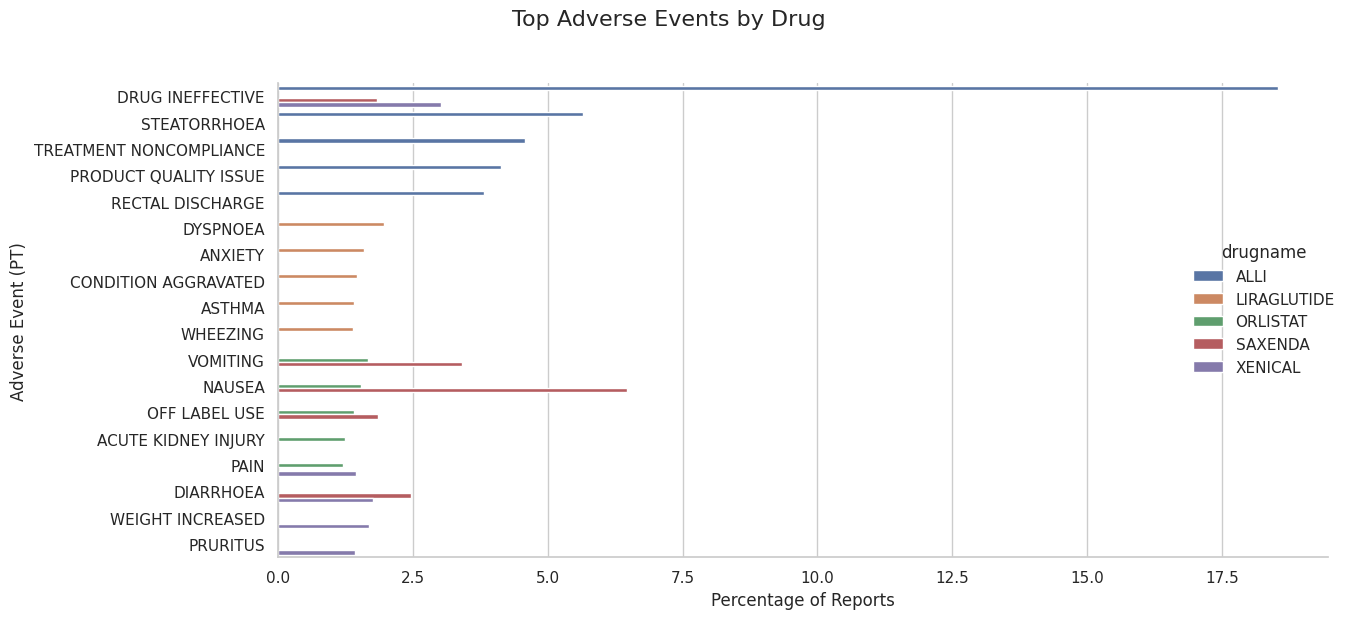

In [58]:
# Set plot aesthetics
sns.set(style='whitegrid')

# Plot
g = sns.catplot(
    data=ae_top_n,
    x='percentage',
    y='pt',
    hue='drugname',
    kind='bar',
    height=6,
    aspect=2,
    sharey=False
)

# Set labels and title
g.set_axis_labels("Percentage of Reports", "Adverse Event (PT)")
g.fig.suptitle("Top Adverse Events by Drug", fontsize=16, y=1.03)

# Show plot
plt.tight_layout()
plt.show()

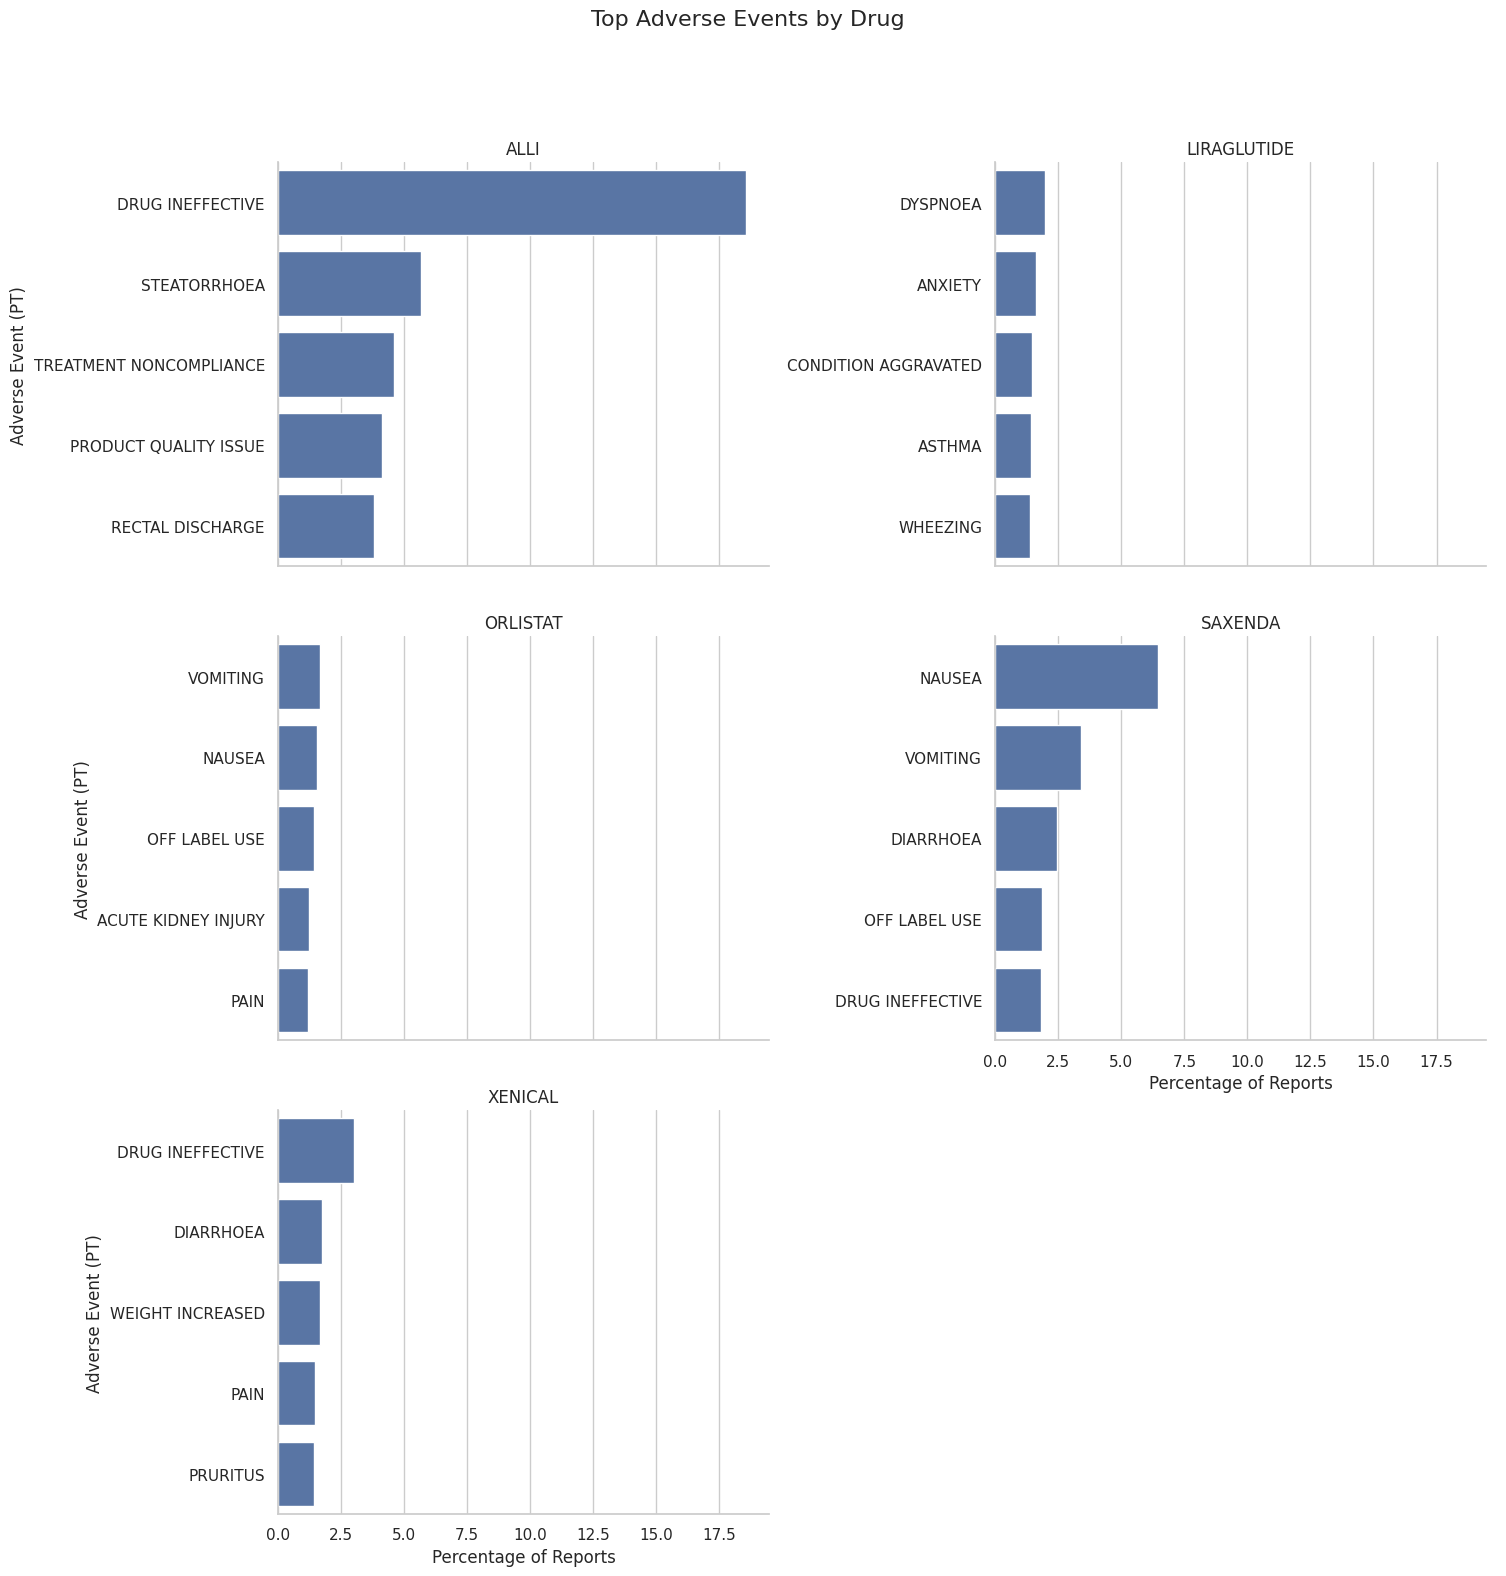

In [59]:
# Set aesthetics
sns.set(style='whitegrid')

# Create FacetGrid: one subplot per drug
g = sns.catplot(
    data=ae_top_n,
    x='percentage',
    y='pt',
    col='drugname',
    kind='bar',
    col_wrap=2,
    height=5,
    aspect=1.5,
    sharey=False
)

# Customize axes
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Percentage of Reports", "Adverse Event (PT)")

# Title for the entire figure
g.fig.suptitle("Top Adverse Events by Drug", fontsize=16, y=1.05)

# Improve layout
plt.tight_layout()
plt.show()

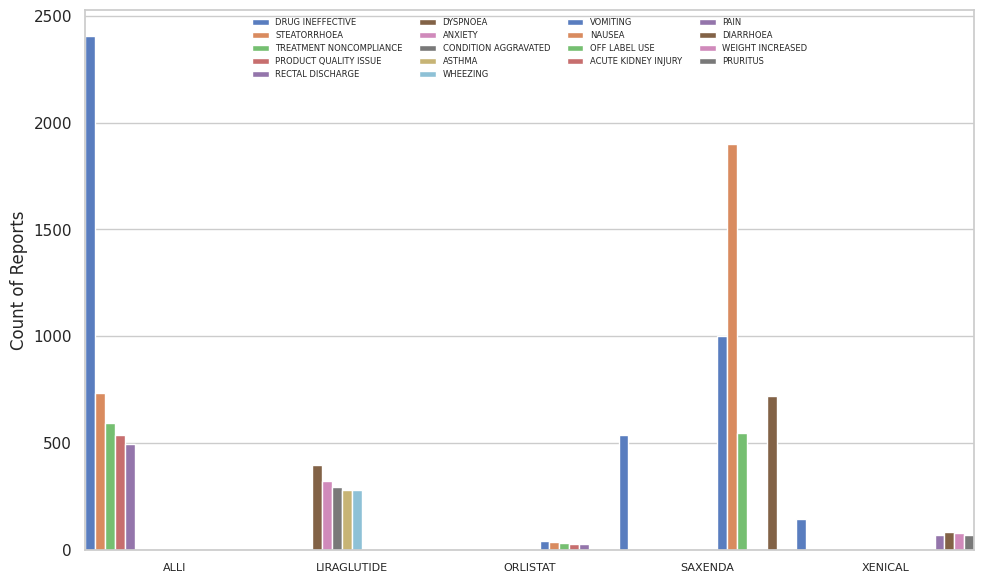

In [11]:
# Set a modern style
sns.set(style='whitegrid', palette='muted')

# Create the figure
plt.figure(figsize=(10, 6))

# Use a visually appealing color palette
palette = sns.color_palette("tab10", n_colors=ae_top_n['pt'].nunique())

# Barplot with improved styling
sns.barplot(
    data=ae_top_n,
    x='drugname',
    y='count',
    hue='pt',
    palette='muted',
    width = 1
)

# Customize axes and title
plt.xlabel("", fontsize=10)
plt.ylabel("Count of Reports", fontsize=12)
#plt.title("Top Adverse Events by Drug", fontsize=14)

# Rotate x-axis labels
plt.xticks(fontsize=8)

# Legend styling
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    ncol=4,  # Adjust based on how many PTs you have
    frameon=False,
    fontsize=6,
    title_fontsize=11
)

plt.tight_layout()
plt.show()

**Temporal trends**

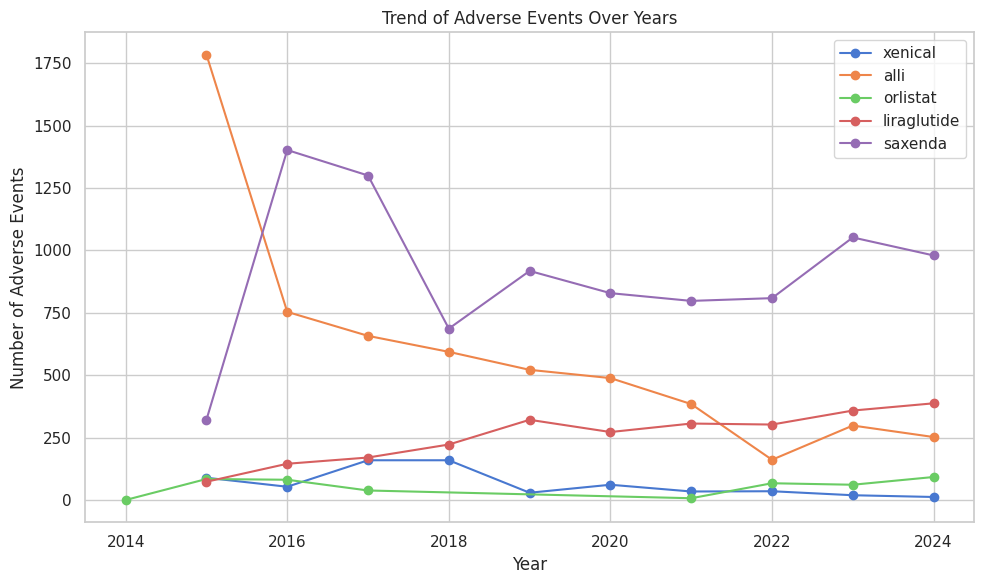

In [13]:
# target drug list
target_drugs = ['xenical', 'alli', 'orlistat', 'liraglutide', 'saxenda']

##copy drug data
df = drug_data.copy()

# Convert date column to datetime if needed
df['fda_dt'] = pd.to_datetime(df['fda_dt'], errors='coerce')

# Extract year
df['year'] = df['fda_dt'].dt.year

# Filter for target drugs only
filtered_df = df[df['drugname'].str.lower().isin(target_drugs)]

filtered_df['drugname'] = filtered_df['drugname'].str.lower()

# Group by drug and year, count the adverse events
trend_data = filtered_df.groupby(['drugname', 'year']).size().reset_index(name='count')

# Plot
plt.figure(figsize=(10, 6))
for drug in target_drugs:
    subset = trend_data[trend_data['drugname'].str.lower() == drug]
    plt.plot(subset['year'], subset['count'], marker='o', label=drug)

plt.xlabel('Year')
plt.ylabel('Number of Adverse Events')
plt.title('Trend of Adverse Events Over Years')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

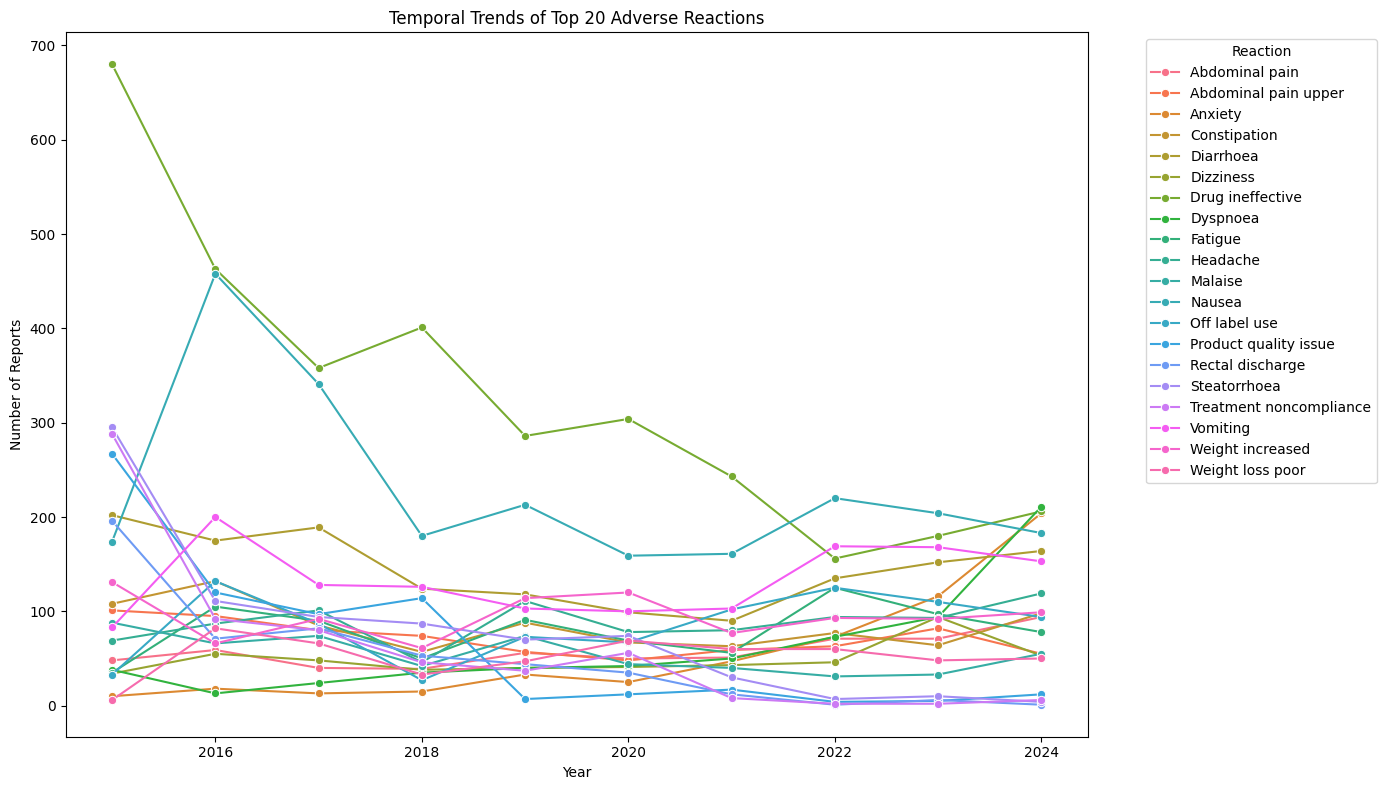

In [46]:
## Temporal trends of the AEs

df = drug_data.copy()
# Clean and convert pt column
df['pt'] = df['pt'].fillna("[]").astype(str)

# Strip brackets, then split into lists
df['pt_cleaned'] = (
    df['pt']
    .str.strip('[]')
    .str.replace("'", "")
    .str.replace('"', '')
    .str.split(',')
)

# Explode the pt_cleaned list into rows
df_exploded = df.explode('pt_cleaned')

# Clean extra whitespace and drop empty strings
df_exploded['pt_cleaned'] = df_exploded['pt_cleaned'].str.strip()
df_exploded = df_exploded[df_exploded['pt_cleaned'] != '']

## convert to datetime
df_exploded['fda_dt'] = pd.to_datetime(df_exploded['fda_dt'], errors = 'coerce')

## extract the year from the date column
df_exploded['fda_dt'] = df_exploded['fda_dt'].dt.year

# Ensure year is numeric
#df_exploded['fda_dt'] = pd.to_numeric(df_exploded['fda_dt'], errors='coerce')

# Get top 20 adverse reactions overall
top_20 = (
    df_exploded['pt_cleaned']
    .value_counts()
    .head(20)
    .index
    .tolist()
)

# Filter to top reactions and group by year
top_df = df_exploded[df_exploded['pt_cleaned'].isin(top_20)]
trend_df = (
    top_df.groupby(['fda_dt', 'pt_cleaned'])
    .size()
    .reset_index(name='count')
)

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=trend_df,
    x='fda_dt',
    y='count',
    hue='pt_cleaned',
    marker='o',
    errorbar = None
)
plt.title('Temporal Trends of Top 20 Adverse Reactions')
plt.xlabel('Year')
plt.ylabel('Number of Reports')
plt.legend(title='Reaction', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Temporal trends for each drug**

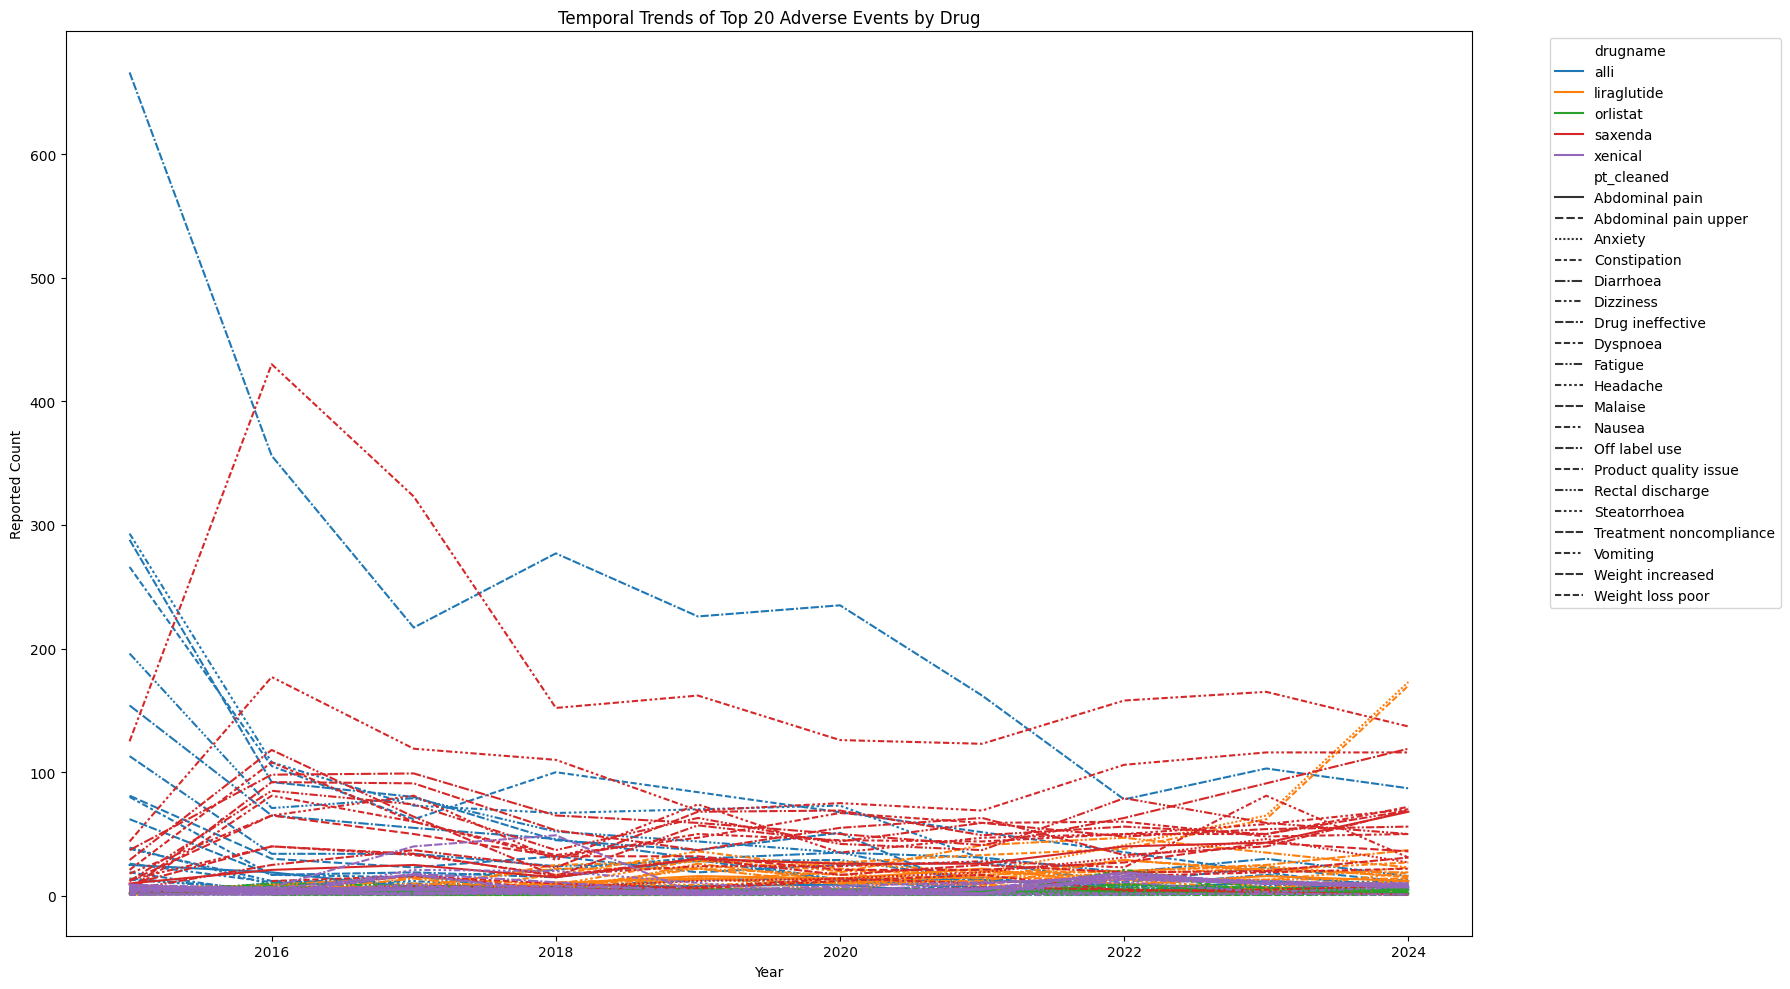

In [47]:
##normalize drugname
df_exploded['drugname'] = df_exploded['drugname'].str.lower()

# Group by fda_dt, pt_cleaned, and drugname
trend_df = (
    df_exploded.groupby(['fda_dt', 'pt_cleaned', 'drugname'])
    .size()
    .reset_index(name='count')
)

# Filter to only include top 20 reactions
top_20_reactions = trend_df.groupby('pt_cleaned')['count'].sum().nlargest(20).index
trend_df_top = trend_df[trend_df['pt_cleaned'].isin(top_20_reactions)]

# Plot
plt.figure(figsize=(18, 10))
sns.lineplot(
    data=trend_df_top,
    x='fda_dt',
    y='count',
    hue='drugname',
    style='pt_cleaned',  # Optional: different line styles for different reactions
    markers=False,
    dashes=True,
    errorbar = None
)

plt.title("Temporal Trends of Top 20 Adverse Events by Drug")
plt.xlabel("Year")
plt.ylabel("Reported Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(False)
plt.show()

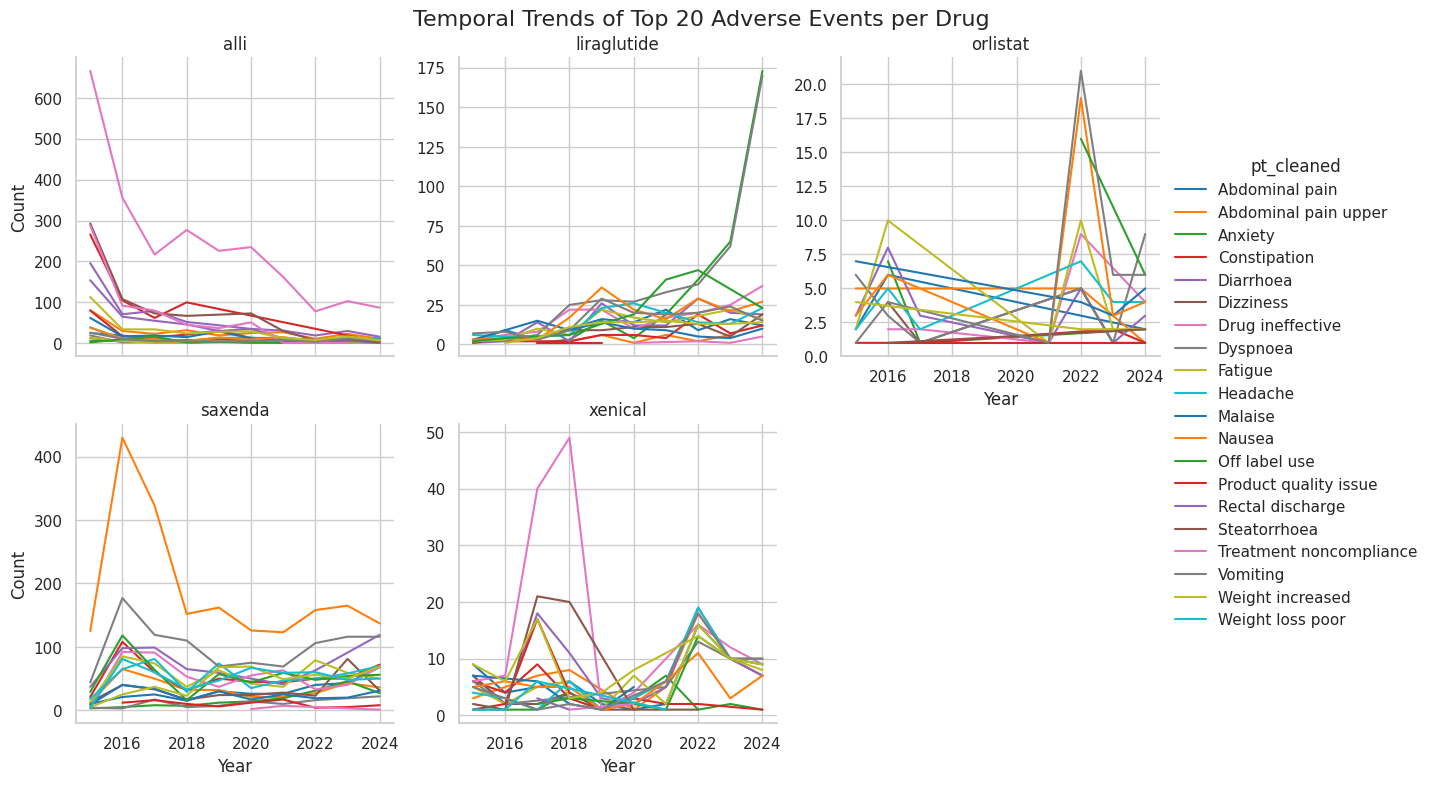

In [48]:
# Set the theme
sns.set_theme(style="whitegrid")

# Plot using FacetGrid: One plot per drug
g = sns.FacetGrid(
    trend_df_top,
    col='drugname',
    hue='pt_cleaned',
    col_wrap=3,
    height=4,
    sharey=False,
    palette='tab10',
)

g.map_dataframe(sns.lineplot,
                'fda_dt',
                'count',
               errorbar = None)
g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Year", "Count")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Temporal Trends of Top 20 Adverse Events per Drug", fontsize=16)
plt.show()

In [49]:
##interactive plot with plotly

fig = px.line(
    trend_df_top,
    x="fda_dt",
    y="count",
    color="pt_cleaned",
    line_group="drugname",
    facet_col="drugname",
    facet_col_wrap=3,
    title="Temporal Trends of Adverse Events by Drug (Interactive)",
    labels={"pt_cleaned": "Adverse Event", "fda_dt": "Year", "count": "Reported Count"},
    markers=True
)

fig.update_layout(height=800, legend_title_text='Adverse Reaction')
fig.show()